### Import needed libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import PIL
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


### Import dataset

In [2]:
# Set initial variables
mask_data_dir = "./data/trainvalidate/WithMask/"
nomask_data_dir = "./data/trainvalidate/WithoutMask/"
img_height = img_width = desired_size = 100
initialdata = []
labels = []
shapes = []

# Import images
for filename in os.listdir(mask_data_dir):
    img=cv2.imread(mask_data_dir+filename)
    initialdata.append(img)
    labels.append(1)
    shapes.append(img.shape)
    
for filename in os.listdir(nomask_data_dir):
    img=cv2.imread(nomask_data_dir+filename)
    initialdata.append(img)
    labels.append(0)
    shapes.append(img.shape)


### Resize images , using 0 padding to maintain aspect ratio

In [3]:
# convert imported images into desired size
data = []
for im in initialdata:
    old_size = im.shape[:2]
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    new_im = cv2.resize(im, (new_size[1], new_size[0]), interpolation=cv2.INTER_CUBIC)

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(new_im, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
    data.append(new_im)

### Split dataset to Train, Validate, and Test sets

In [4]:
#Split data between train, validation, and test 
trainvalid_data, test_data, trainvalid_label, test_label = train_test_split(data, labels, test_size=0.05)
train_data, valid_data, train_label, valid_label = train_test_split(trainvalid_data, trainvalid_label, test_size=0.2)

#Convert lists back to numpy array
train_data = np.asarray(train_data)
valid_data = np.asarray(valid_data)
test_data = np.asarray(test_data)
train_label = np.asarray(train_label)
valid_label = np.asarray(valid_label)
test_label = np.asarray(test_label)

### Show count of each set then plot histogram

Dataset        Total Size     Without Mask   With Mask      
Total          6802           5909 (87.0%)   893 (13.0%)    
Training       5168           4498 (87.0%)   670 (13.0%)    
Validation     1293           1123 (87.0%)   170 (13.0%)    
Test           341            288 (84.0%)    53 (16.0%)     


(array([288.,  53.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

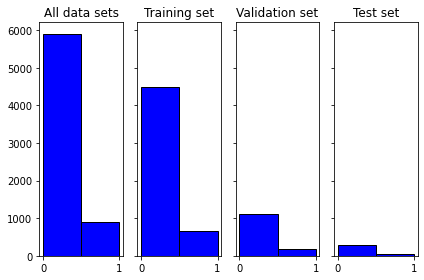

In [5]:
#Count data in each dataset
tableheader = ["Dataset", "Total Size", "Without Mask", "With Mask"]
tabledata = list()
format_row = "{:<15}" * (len(tableheader))
print(format_row.format(*tableheader))

labeldict = {"Total": labels, "Training": train_label, "Validation": valid_label, "Test": test_label}
for key in labeldict:
    total = len(labeldict[key])
    count_no_mask = count_with_mask = 0
    for label in labeldict[key]: 
        if label == 0: count_no_mask+=1
    count_with_mask = total-count_no_mask
    tabledata.append((str(key), str(total), str(count_no_mask) + " (" + str(round(count_no_mask/total, 2)*100) +"%)", str(count_with_mask) + " (" + str(round(count_with_mask/total, 2)*100) +"%)"))
    
for row in tabledata:
    print(format_row.format(*row))

#Plot histograms for each dataset 
fig, axs = plt.subplots(1, 4, sharey=True, tight_layout=True)
axs[0].set_title('All data sets')
axs[0].hist(labels, bins=2, color = 'blue', edgecolor = 'black')
axs[1].set_title('Training set')
axs[1].hist(train_label, bins=2, color = 'blue', edgecolor = 'black')
axs[2].set_title('Validation set')
axs[2].hist(valid_label, bins=2, color = 'blue', edgecolor = 'black')
axs[3].set_title('Test set')
axs[3].hist(test_label, bins=2, color = 'blue', edgecolor = 'black')

### Show sample images

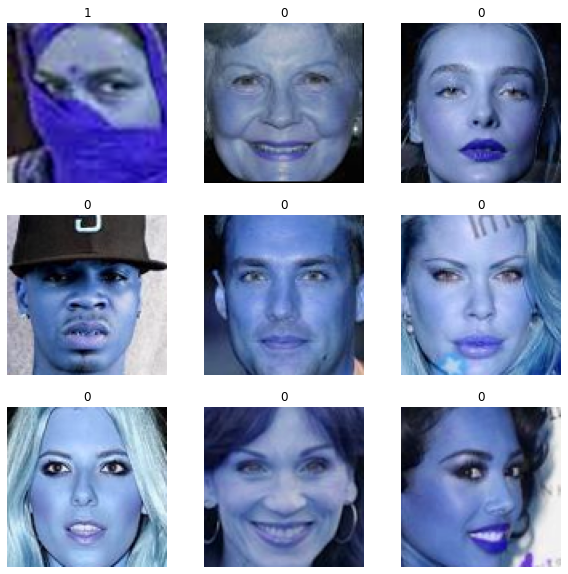

In [6]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(train_data[i].astype("uint8"))
    plt.title(train_label[i])
    plt.axis("off")
    

### Enable memory storage and prefetch (Disabling this for now, may use later)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Set the arguments(may use Grid Search later)

In [7]:
epochs=3
batch_size=100

### Data Augmentation

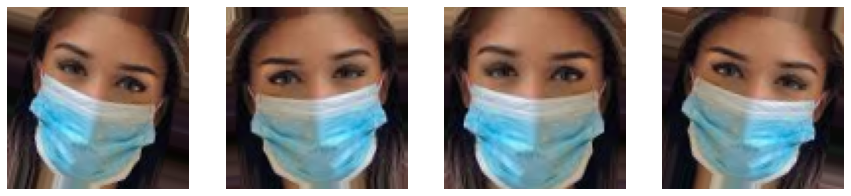

In [8]:
datagenerator = ImageDataGenerator(
        rotation_range=20,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

datagenerator.fit(train_data)

# Pring sample of augmented image
image = load_img('data/trainvalidate/WithMask/148.png')
image_array = np.expand_dims(img_to_array(image), 0)
aug_iter = datagenerator.flow(image_array, batch_size=1)
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))
for i in range(4):
    image = next(aug_iter)[0].astype('uint8')
    ax[i].imshow(image)
    ax[i].axis('off')

### Model 1: Augment and rescale data, then build, compile and train CNN model

In [9]:
model=Sequential()
model.add(layers.experimental.preprocessing.Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))
model.add(layers.Conv2D(16,(3,3),activation='relu',padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128,activation='relu'))
#model.add(layers.BatchNormalization())
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

history = model.fit_generator(datagenerator.flow(train_data, train_label,batch_size=batch_size), epochs=epochs, validation_data=(valid_data,valid_label))


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 40000)             0         
_________________________________________________________________
dropout (Dropout)            (None, 40000)             0

c:\program files\python39\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
52/52 [==============================] - 27s 505ms/step - loss: 0.6510 - accuracy: 0.8148 - val_loss: 0.1823 - val_accuracy: 0.8685
Epoch 2/3
52/52 [==============================] - 28s 532ms/step - loss: 0.1706 - accuracy: 0.9304 - val_loss: 0.1565 - val_accuracy: 0.9753
Epoch 3/3
52/52 [==============================] - 28s 539ms/step - loss: 0.1504 - accuracy: 0.9675 - val_loss: 0.1715 - val_accuracy: 0.9613


### Model 2: Augment and rescale data, then build, compile and train CNN model

In [10]:
model2=Sequential()
model2.add(layers.experimental.preprocessing.Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))
model2.add(layers.Conv2D(16,(3,3),activation='relu',padding='same'))
model2.add(layers.MaxPooling2D(pool_size=(2,2)))
model2.add(layers.Conv2D(32,(3,3),activation='relu',padding='same'))
model2.add(layers.MaxPooling2D(pool_size=(2,2)))
model2.add(layers.Conv2D(64,(3,3),activation='relu',padding='same'))
model2.add(layers.MaxPooling2D(pool_size=(2,2)))
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(128,activation='relu'))
#model.add(layers.BatchNormalization())
model2.add(layers.Dense(1,activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model2.summary()

history2 = model2.fit_generator(datagenerator.flow(train_data, train_label,batch_size=batch_size), epochs=epochs, validation_data=(valid_data,valid_label))


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 64)       

### Model 1 vs Model 2: Training and Validation Accuracy and Loss

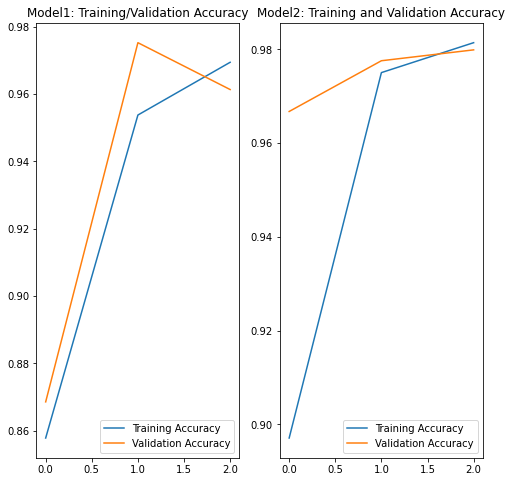

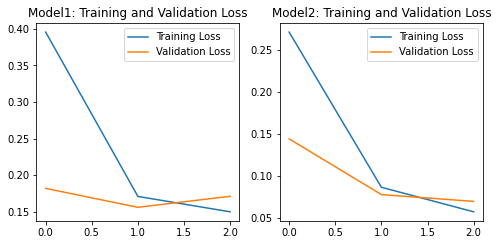

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Model1: Training/Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc2, label='Training Accuracy')
plt.plot(epochs_range, val_acc2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Model2: Training and Validation Accuracy')

plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Model1: Training and Validation Loss')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss2, label='Training Loss')
plt.plot(epochs_range, val_loss2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Model2: Training and Validation Loss')

plt.show()

### Model 1 vs Model 2: Testing

In [12]:
score, acc = model.evaluate(test_data, test_label, batch_size=100)
print(acc)

score2, acc2 = model2.evaluate(test_data, test_label, batch_size=100)
print(acc2)

4/4 [==============================] - 0s 89ms/step - loss: 0.1630 - accuracy: 0.9707
0.9706745147705078
4/4 [==============================] - 0s 81ms/step - loss: 0.0498 - accuracy: 0.9824
0.9824047088623047
